### Libraries

In [112]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import os
import requests

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image

warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset

In [3]:
books_data = pd.read_csv("books_data.csv")
books_data.head()

Unnamed: 0  user_id                   location      age        isbn  \
0           0        2  stockton, california, usa  18.0000  0195153448   
1           1        8   timmins, ontario, canada  34.7439  0002005018   
2           2    11400    ottawa, ontario, canada  49.0000  0002005018   
3           3    11676              n/a, n/a, n/a  34.7439  0002005018   
4           4    41385   sudbury, ontario, canada  34.7439  0002005018   

   rating           book_title           book_author  year_of_publication  \
0       0  Classical Mythology    Mark P. O. Morford               2002.0   
1       5         Clara Callan  Richard Bruce Wright               2001.0   
2       0         Clara Callan  Richard Bruce Wright               2001.0   
3       8         Clara Callan  Richard Bruce Wright               2001.0   
4       0         Clara Callan  Richard Bruce Wright               2001.0   

                 publisher                                              img_s  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
1    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
2    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
3    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
4    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

                                               img_m  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0002005018.0...   
3  http://images.amazon.com/images/P/0002005018.0...   
4  http://images.amazon.com/images/P/0002005018.0...   

                                               img_l  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0002005018.0...   
3  http://images.amazon.com/images/P/0002005018.0...   
4  http://images.amazon.com/images/P/0002005018.0...   

                                             Summary Language  \
0  Provides an introduction to classical myths pl...       en   
1  In a small town in Canada, Clara Callan reluct...       en   
2  In a small town in Canada, Clara Callan reluct...       en   
3  In a small town in Canada, Clara Callan reluct...       en   
4  In a small town in Canada, Clara Callan reluct...       en   

             Category      city       state country  
0  ['Social Science']  stockton  california     usa  
1       ['Actresses']   timmins     ontario  canada  
2       ['Actresses']    ottawa     ontario  canada  
3       ['Actresses']       NaN         NaN     NaN  
4       ['Actresses']   sudbury     ontario  canada

### Preprocessing

In [4]:
books_data.isnull().any()

Unnamed: 0             False
user_id                False
location               False
age                    False
isbn                   False
rating                 False
book_title             False
book_author            False
year_of_publication    False
publisher              False
img_s                  False
img_m                  False
img_l                  False
Summary                False
Language               False
Category               False
city                    True
state                   True
country                 True
dtype: bool

In [19]:
df = books_data.copy()
df.dropna(inplace = True)

# Remove unnecessary columns
df.drop(columns = ['Unnamed: 0','location','isbn',
                   'img_s','img_m','city','age',
                   'state','Language','country',
                   'year_of_publication'],axis=1,inplace = True) 
# Remove Category = 9 
df.drop(index=df[df['Category'] == '9'].index, inplace=True)

# remove records with 0 rating
df.drop(index=df[df['rating'] == 0].index, inplace=True)

# remove the unnecessary characters from category column
df['Category'] = df['Category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df.head()

user_id  rating    book_title           book_author  \
1         8       5  Clara Callan  Richard Bruce Wright   
5     67544       8  Clara Callan  Richard Bruce Wright   
9    123629       9  Clara Callan  Richard Bruce Wright   
11   200273       8  Clara Callan  Richard Bruce Wright   
12   210926       9  Clara Callan  Richard Bruce Wright   

                publisher                                              img_l  \
1   HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
5   HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
9   HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
11  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
12  HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   

                                              Summary   Category  
1   In a small town in Canada, Clara Callan reluct...  Actresses  
5   In a small town in Canada, Clara Callan reluct...  Actresses  
9   In a small town in Canada, Clara Callan reluct...  Actresses  
11  In a small town in Canada, Clara Callan reluct...  Actresses  
12  In a small town in Canada, Clara Callan reluct...  Actresses

## Content based collaborative filtering

In [121]:
pd.DataFrame(df['book_title'].value_counts())

book_title
Wild Animus                                                548
The Da Vinci Code                                          471
The Secret Life of Bees                                    388
The Nanny Diaries: A Novel                                 370
The Red Tent (Bestselling Backlist)                        363
...                                                        ...
Maxton Bequest (Harlequin Romance, 3042)                     1
Beadwork Creates Beaded Beads: 30 Designs (Bead...           1
The Dore Illustrations for Dante's Divine Comedy             1
Kailey (American Girl Today)                                 1
Canada's Navy: The First Century (General Inter...           1

[73073 rows x 1 columns]

In [123]:
def content_based_filtering(book_title):
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        ratings = pd.DataFrame(df['book_title'].value_counts())
        rare_books = ratings[ratings['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')

            
        else:
            common_books = common_books.drop_duplicates(subset = ["book_title"])
            common_books.reset_index(inplace = True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            
            x_counts_df  = pd.DataFrame(count_matrix.toarray())
            x_counts_df.columns = cv.get_feature_names()
            
            # TODO
            cosine_data_ = pd.DataFrame(cosine_sim)
            cosine_data_.index = common_books.book_title
            cosine_data_.columns = common_books.book_title
            #TODO data vizualization
            
           
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,8))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="Black",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

            

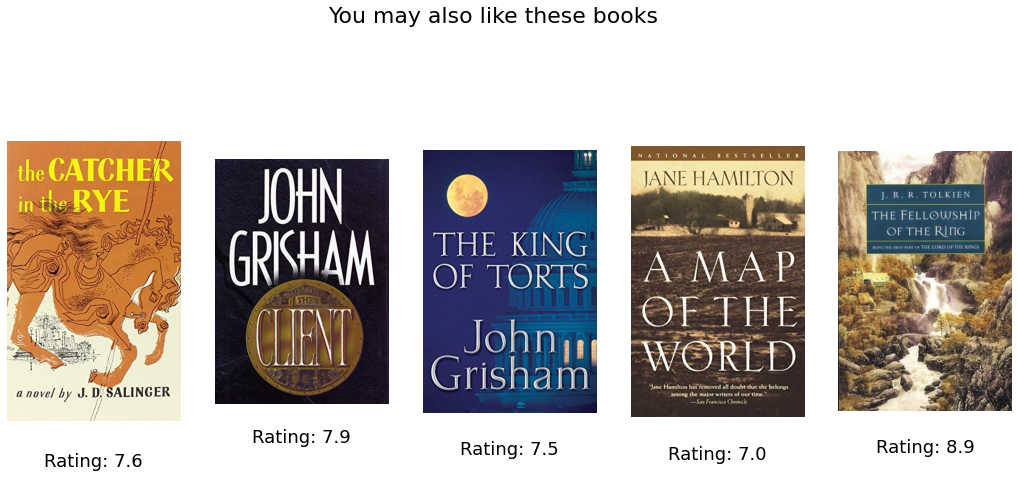

In [124]:
content_based_filtering("The Da Vinci Code")

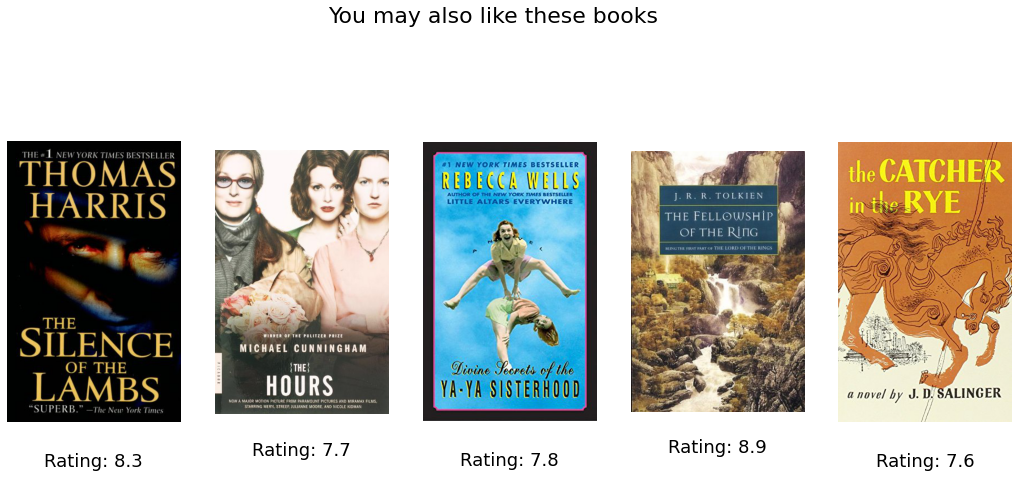

In [125]:
content_based_filtering("The Nanny Diaries: A Novel")

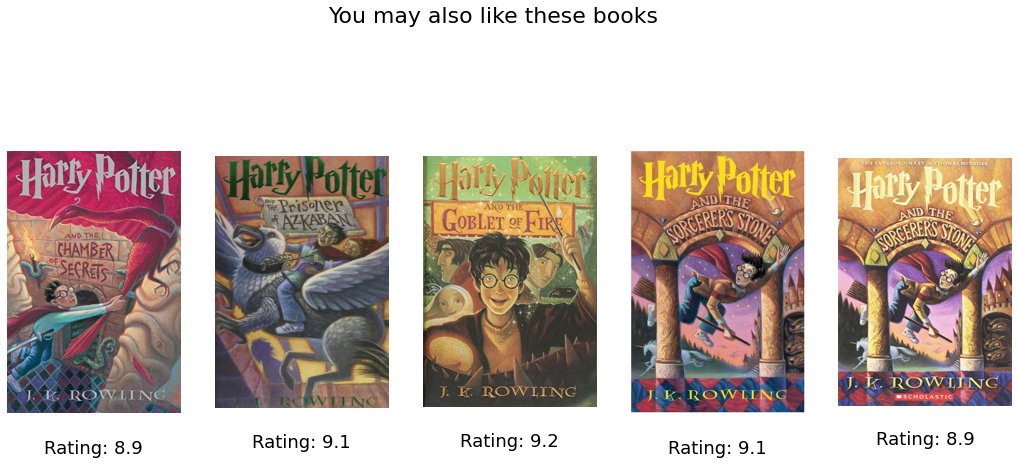

In [126]:
content_based_filtering("Harry Potter and the Order of the Phoenix (Book 5)")

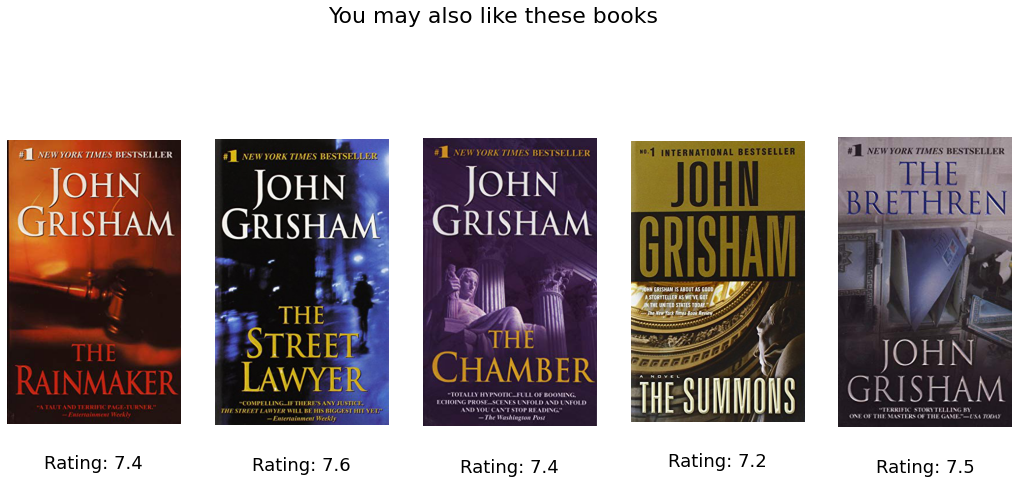

In [127]:
content_based_filtering("The Testament")

In [128]:
content_based_filtering("Clara Callan")

There are no recommendations for this book
Try: 

Bridget Jones's Diary 

A Prayer for Owen Meany 



In [102]:
#Count vectorization
x_counts_df

1st  45  451  against  agency  airframe  albom  alex  alexander  along  \
0     0   0    0        0       0         0      0     0          0      0   
1     0   0    0        0       0         0      0     0          0      0   
2     0   0    0        0       0         1      0     0          0      0   
3     0   0    0        0       0         0      0     0          0      0   
4     0   0    0        0       0         0      0     0          0      0   
..  ...  ..  ...      ...     ...       ...    ...   ...        ...    ...   
95    0   0    0        0       0         0      0     0          0      0   
96    0   0    0        0       0         0      0     0          0      0   
97    0   0    0        0       0         0      0     0          0      0   
98    0   0    0        0       0         0      0     0          0      0   
99    0   0    0        0       0         0      0     0          0      0   

    ...  wind  witch  with  work  works  world  ya  you  young  your  
0   ...     0      0     0     0      0      0   0    0      0     0  
1   ...     0      0     0     0      0      0   0    0      0     0  
2   ...     0      0     0     0      0      0   0    0      0     0  
3   ...     0      0     0     0      0      0   0    0      0     0  
4   ...     0      0     0     0      0      0   0    0      0     0  
..  ...   ...    ...   ...   ...    ...    ...  ..  ...    ...   ...  
95  ...     0      0     0     0      0      0   0    0      0     0  
96  ...     0      0     0     0      0      0   0    0      0     0  
97  ...     0      0     0     0      0      0   0    0      0     0  
98  ...     0      0     0     0      0      0   0    0      0     0  
99  ...     0      0     0     0      0      0   0    0      0     0  

[100 rows x 487 columns]

In [129]:
cosine_data_["The Da Vinci Code"].sort_values(ascending = False)

book_title
The Da Vinci Code                                   1.000000
The Catcher in the Rye                              0.426401
The Client                                          0.400892
The King of Torts                                   0.353553
A Map of the World                                  0.335410
                                                      ...   
ANGELA'S ASHES                                      0.000000
Angela's Ashes (MMP) : A Memoir                     0.000000
A Heartbreaking Work of Staggering Genius           0.000000
Seabiscuit: An American Legend                      0.000000
Nickel and Dimed: On (Not) Getting By in America    0.000000
Name: The Da Vinci Code, Length: 100, dtype: float64

### Content based filtering based on Summary

In [131]:
df["Summary"]

1          In a small town in Canada, Clara Callan reluct...
5          In a small town in Canada, Clara Callan reluct...
9          In a small town in Canada, Clara Callan reluct...
11         In a small town in Canada, Clara Callan reluct...
12         In a small town in Canada, Clara Callan reluct...
                                 ...                        
1031151    Based on two years of interviews and research,...
1031162    A grandmother tells the story of her eventful ...
1031169    A tongue-in-cheek survival guide for single pe...
1031171    A daring twist on the travel-adventure genre t...
1031173    These hilarious stories by the creator of publ...
Name: Summary, Length: 217314, dtype: object

In [149]:
def content_based_filtering_2(book_title):
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        ratings = pd.DataFrame(df['book_title'].value_counts())
        rare_books = ratings[ratings['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')

            
        else:
            common_books = common_books.drop_duplicates(subset = ["book_title"])
            common_books.reset_index(inplace = True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            
            summary_filtered = []
            for i in common_books['Summary']:
                
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['Summary'] = summary_filtered   
            cv = CountVectorizer()
            
            count_matrix = cv.fit_transform(common_books['Summary'])
            
            cosine_sim = cosine_similarity(count_matrix)
            
            
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

            
            
            
            

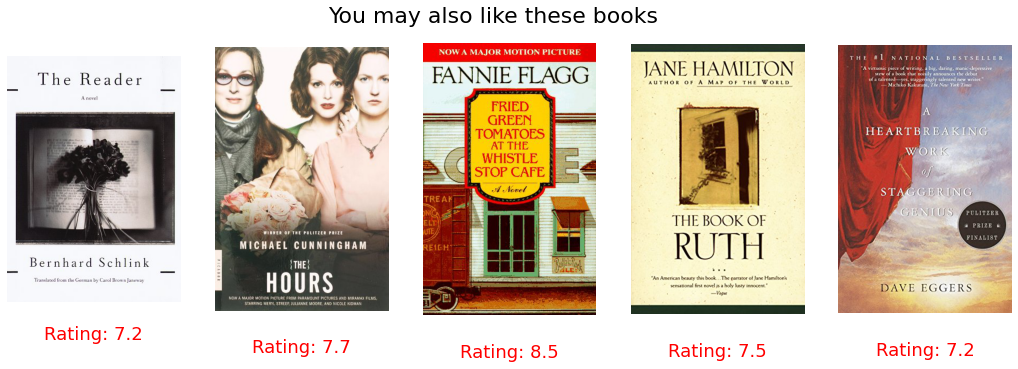

In [150]:
content_based_filtering_2("The Testament")

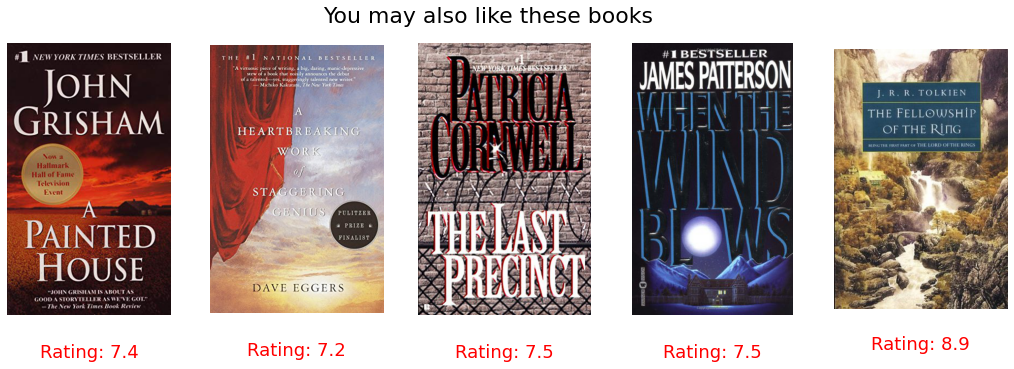

In [151]:
content_based_filtering_2("The Da Vinci Code")

## Item based recommender

In [161]:
def item_based_filtering(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'],
                                                    values='rating')
            #print(user_book_df)
        
            book = user_book_df[book_title]
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)
            print(recom_data)
            
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            recom_data = recom_data[0:5]    
            recom_data.columns = ['book_title','corr']
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(recom_data['book_title'].tolist())):
        
                url = common_books.loc[common_books['book_title'] == recom_data['book_title'].tolist()[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recom_data['book_title'].tolist()[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
    else:
        print('Cant find book in dataset, please check spelling')

                                           book_title         0
0                                         Wild Animus  1.000000
1                                       The Testament  1.000000
2                                   The Street Lawyer  0.844485
3                           Girl with a Pearl Earring  0.824530
4                                         The Summons  0.793360
5                                            Timeline  0.786728
6   The Fellowship of the Ring (The Lord of the Ri...  0.784465
7                          Interview with the Vampire  0.732194
8                                         Good in Bed  0.638915
9                                     A Painted House  0.620322
10                              Bridget Jones's Diary  0.577196
11                             Snow Falling on Cedars  0.564019
12                                     A Time to Kill  0.560821
13    Divine Secrets of the Ya-Ya Sisterhood: A Novel  0.500000
14                The Red Tent (Bestsell

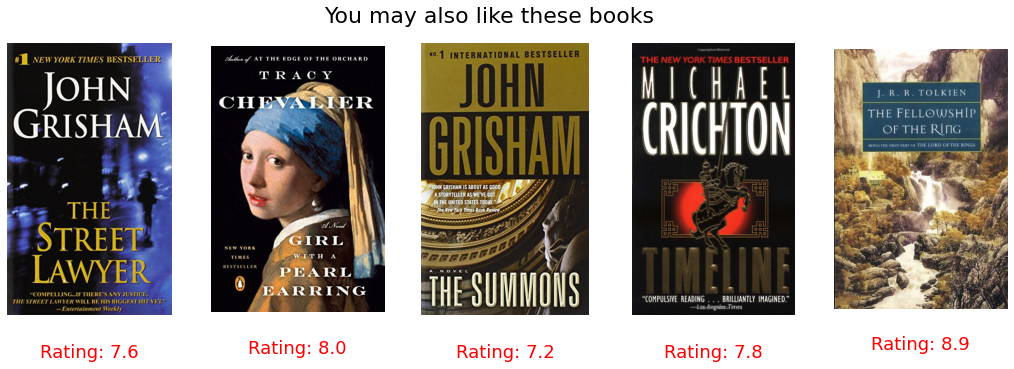

In [162]:
item_based_filtering("The Testament")